In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import urllib3
# import gzip
# import zlib
import re
import time
import numpy
# import math
import random
import os
# import sys
import json
# import cython
import pandas
# import string
import nltk
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.models import Word2Vec
from numpy import sin, cos, tan, log, log10, pi, average, sqrt, std, deg2rad, rad2deg, linspace, asarray, dot
from numpy.random import random, randint, normal, shuffle, choice
from numpy.linalg import norm

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

https://osf.io/gcdbt/

#Fix UMBC Corpus

In [ ]:
########
#
# Setup UMBC corpus by cleaning, lemmatizing, splitting into sentences, and identifying olfactory contexts.
# Saves .json corpus files as well as .json files specifying olfactory context sentences in each file.
#
########    
    
def fix_UMBC_corpus(corpusdir, targetdir=[], POStags = [], startfile=[], NounTags = [], 
                    AdjTags = [], VerbTags = [], AdvTags = [], OlfWords = [], min_Ns = []):    
    
    ######
    # Setup
    ######
    
    # Get start time
    starttime = time.time()
    
    print('\n\n**************************************************************')
    print('Starting to fix UMBC corpus, this will take some time.\n')
    
    # Get file names
    files = [cfile for cfile in os.listdir(corpusdir) if (re.search(r'.*.possf2$', cfile))]
    
    if startfile:
        print('Starting with file ' + files[startfile])
        files = files[startfile:len(files)]
    else:
        startfile = 0
    
    # Check taget dir
    if not targetdir:
        targetdir = corpusdir
    
    # Fix POS search string
    possearch = "(" + "|".join(POStags) + ")"
    
    # Setup wordnet lemmatiser
    lt = WordNetLemmatizer()
    
    # Setup POS list to return
    POS = []


    #########
    # Loop over files
    #########

    for idx, cfile in enumerate(files):
    
        # Get file start time
        filestarttime = time.time()
    
        print('\nWorking file: ' + cfile + '....\n')
        
        # Setup .json lists to be saved
        nlines = []
        olflines = []


        ########
        # Loop over lines in current file
        ########
        
        for cline in open(corpusdir + cfile, 'r', encoding='utf8'):
            
            # Split current line
            cline = cline.split()
    
            ######
            # Set up current line by removing trash, converting to lower case, lemmatizing, 
            # and categorizing as OLF or not
            ######
    
            # Setup new line list
            nline = []
            OLF = False
        
            for word in cline:
       
                # only work with current word if acceptable POS is found 
                if (re.search(r'^.*_' + possearch + '$', word)):
        
                    # get word and POS tag    
                    hit = re.search(r'(^.*)_(.*$)', word)
                    cword = hit.group(1)
                    cword = cword.lower()
                    cPOS = hit.group(2)
        
                    # save POS
                    if not any([cPOS == nPOS for nPOS in POS]):
                        POS.append(cPOS)
       
                    # Lemmatize if any noun, verb, adj, or adv POS is found
                    if any([cPOS == nPOS for nPOS in NounTags]):
                        cword = lt.lemmatize(cword, pos='n') + '_' + cPOS
                    elif any([cPOS == nPOS for nPOS in VerbTags]):
                        cword = lt.lemmatize(cword, pos='v') + '_' + cPOS
                    elif any([cPOS == nPOS for nPOS in AdjTags]):
                        cword = lt.lemmatize(cword, pos='a') + '_' + cPOS
                    elif any([cPOS == nPOS for nPOS in AdvTags]):
                        cword = lt.lemmatize(cword, pos='r') + '_' + cPOS
                    else:
                        cword = cword + '_' + cPOS
   
                    # check if cword is olfactory-related
                    if any([re.search(oword, cword) for oword in OlfWords]):
                        OLF = True
               
                    # check if cword is punctuation. In that case, end sentence
                    # and add data to lists
                    if cPOS == '.':
                        nlines.append(nline)
                
                        # save sentence number to indicate that it is an olfactory context
                        if OLF:
                            olflines.append(len(nlines)-1)
                            print('.', end='')
                    
                        # start new sentence, increment sentence counter and reset OLF flag    
                        nline = []
                        OLF = False
    
                    # Else add current word to sentence
                    else:
                        nline.append(cword)
        
            # Current paragraph is done. Add final sentence if it has not been done already
            # (i.e., if it does not end with a punctuation mark)
            if cPOS != '.':
                nlines.append(nline)
             
                # save sentence number to indicate that it is an olfactory context
                if OLF:
                    olflines.append(len(nlines)-1)
                    print('.', end='')
                   
                # start new sentence, increment sentence counter and reset OLF flag    
                nline = []
                OLF = False
                
        # Current file is done. Dump .json-sentence file and .json-olf ID file
        print('\n\n**************************************************************')
        print(cfile + ' is done! Saving resulting .json files....\n')
        
        cfile = open(targetdir + 'UMBC_lines_' + str(idx + 1 + startfile) + '.json', 'w')
        json.dump(nlines, cfile)
        cfile.close()
        
        cfile = open(targetdir + 'UMBC_olfIDs_' + str(idx + 1 + startfile) + '.json', 'w')
        json.dump(olflines, cfile)
        cfile.close()
        print('It took ' + str(time.time() - filestarttime) + ' seconds to work ' + str(len(nlines)) + ' sentences.')
              
    # All files are done. Report and return POS tags
    print('\n********************************************************************')
    print('All files done! Returning identified POS tags.\n')
    print('It took ' + str(time.time() - starttime) + ' seconds to work ' + str(len(files)) + ' files.')
    return(POS)

In [ ]:
########
# 
# Setup UBMC corpus
#
########

corpusdir = '/content/drive/My Drive/umbc/'
targetdir = '/content/drive/My Drive/umbc/'

POStags = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNS', 'NNP',
           'NNPS', 'PDT', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 
           'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '\.']
NounTags = ['NN', 'NNS', 'NNP', 'NNPS']
AdjTags = ['JJ', 'JJR', 'JJS']
VerbTags = ['MD', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
AdvTags = ['RB', 'RBR', 'RBS']

#########
#
# Extract olfactory IDs for olfactory + gustatory terms
#
#########


OlfWords = ['^feel_.*$', '^feeling_.*$', '^feelings_.*$', '^feels_.*$', '^felt_.*$']

POS = fix_UMBC_corpus(corpusdir, targetdir=targetdir, POStags = POStags, NounTags = NounTags, AdjTags = AdjTags,
                      VerbTags = VerbTags, AdvTags = AdvTags, OlfWords = OlfWords)



**************************************************************
Starting to fix UMBC corpus, this will take some time.


Working file: delorme.com_shu.pages_0.possf2....

............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

#Train Word2Vec Model

In [ ]:
########
#
# Iterator that feeds sentences from the UMBC corpus
#
########

class feed_UMBC_Corpus(object):
    
    # Setup feed
    # Get json file IDs and save start time
    def __init__(self, dir_name, ctxtdir = [], OlfContextsOnly = False, MergePOS = True):
        self.dir_name = dir_name
        
        if not ctxtdir:
            self.ctxtdir = dir_name
        else:
            self.ctxtdir = ctxtdir
            
        self.files = [cfile for cfile in os.listdir(dir_name) if (re.search(r'^UMBC_lines.*json$', cfile))]
        self.IDs = [int(re.search(r'^UMBC_lines_([0-9]{1,3}).json', cfile).group(1)) for cfile in self.files]
        self.starttime = time.time()
        self.OlfContextsOnly = OlfContextsOnly
        self.MergePOS = MergePOS
        
        print('\nSTARTING UP NEW UMBC CORPUS FEED')
        print('***************************\n')
    
    # Iterate over file IDs
    def __iter__(self):
        
        for cID in self.IDs:
            
            # Setup for current file. Save file name and file start time
            self.filetime = time.time()
            self.cfilename = 'UMBC_lines_' + str(cID) + '.json'
            print('\nWorking file ' + self.cfilename + '...')
          
            # Open current file
            with open(os.path.join(self.dir_name, self.cfilename), 'r') as cfile:
                cSentences = json.load(cfile)
            cfile.close()
            
            # If only olfactory sentences are to be fed, feed on basis of
            # Olfactory sentence identifiers
            if self.OlfContextsOnly: 
                print('Feed is restricted to olfactory sentences only.')
                with open(os.path.join(self.ctxtdir, 'UMBC_olfIDs_' + str(cID) + '.json'), 'r') as cfile:
                    cIDs = json.load(cfile)
                cfile.close()
                
                # Iterate over olfactory sentences
                for cID in cIDs:
                    # If POS-es are to be merged, remove final POS signs and send
                    if self.MergePOS:
                        yield([re.search(r'(^.*_COLL|^.*_..)($|.*$)', n).group(1) for n in cSentences[cID]])
                    # Else send-as-is
                    else:        
                        yield(cSentences[cID])
            
            # Else iterate over all sentences
            else:
                for cSentence in cSentences: 
                    # If POS-es are to be merged, remove final POS signs and send
                    if self.MergePOS:
                        yield([re.search(r'(^.*_COLL|^.*_..)($|.*$)', n).group(1) for n in cSentence])
                    # Else send-as-is
                    else:
                        yield(cSentence)
            
            # Current file is done, provide feedback
            print('\n**************************************************************')
            print(self.cfilename + ' is done!')
            
            if self.OlfContextsOnly:
                print('Nr of sentences fed: ' + str(len(cIDs)))    
            else:
                print('Nr of sentences fed: ' + str(len(cSentences)))  
                 
            print('File processing time: ' + str(time.time() - self.filetime))
  
        # All files are done, provide feedback
        print('\n\n**************************************************************')
        print('All ' + str(len(self.IDs)) + ' files are done!') 
        print('Total processing time: ' + str(time.time() - self.starttime))

In [ ]:
########
# Trimming rule for empty words
########
      
def trimrule(word, count, min_count):
    # trim out empty words
    if word.startswith("_"):
        return gensim.utils.RULE_DISCARD
    
    # remove pos tag
    cword = re.search(r'(^.*)_.*', word)
    
    # trim out non-tagged words
    if not cword:
        return gensim.utils.RULE_DISCARD
    
    # trim out short abbreviations
    if re.match(r'^.\.$', cword.group(1)):
        return gensim.utils.RULE_DISCARD

    return gensim.utils.RULE_DEFAULT

In [ ]:
#########
#
# Training of language model
#
##########

#######
# corpusdir and target model dir
#######

corpusdir =  '/content/drive/My Drive/umbc/'  
modeldir = '/content/drive/My Drive/umbc/'


########
# Model setup (build vocabulary etc)
########

# Initiation of model. Empty model is set up first. Then the vocabulary is build on the basis of the whole corpus.
# Also, the corpus is properly prepared

corpus = feed_UMBC_Corpus(corpusdir, OlfContextsOnly=True)  
olfmodel = Word2Vec(corpus, min_count=10, iter=30, window=5, size=200, workers=4, sg=0, trim_rule=trimrule)
olfmodel.save(modeldir + u'OlfModelIter30_nonSG')

#Load Model

In [ ]:
model = Word2Vec.load('/content/drive/MyDrive/UMBC_feel_data/OlfModelIter30_nonSG')
print(model)

Word2Vec(vocab=37281, size=200, alpha=0.025)


In [ ]:
vocab_obj = model.wv.vocab["peru_NN"]
print(vocab_obj.count)

89


In [ ]:
print(model.wv.most_similar(positive=['stress_NN'], topn=10))

[('anxiety_NN', 0.6889177560806274), ('depression_NN', 0.6018229126930237), ('burnout_NN', 0.5939035415649414), ('fatigue_NN', 0.5818719863891602), ('trauma_NN', 0.565748929977417), ('stressor_NN', 0.5531803369522095), ('strain_NN', 0.551838755607605), ('isolation_NN', 0.5501328110694885), ('sleepiness_NN', 0.5488513708114624), ('distress_NN', 0.5386402606964111)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
df = pandas.read_csv("/content/drive/MyDrive/UMBC_feel_data/purple_feel_oai - Copy.csv")
df

,Unnamed: 0,OlfN,TotalN,Tokens,OAI,OSI
0,confidence_NN,149,19187,"['confidence_NN', 'confidence_NNS']",-7.008673,11.533081
1,hot_JJ,186,23908,"['hot_JJ', 'hot_JJS']",-7.006047,11.213091
2,home_NN,1297,161002,"['home_NN', 'home_NNS', 'home_NNP', 'home_NNPS']",-6.955756,8.411287
3,heavy_JJ,194,23971,"['heavy_JJ', 'heavy_JJR', 'heavy_JJS']",-6.949090,11.152337
4,obligation_NN,194,23818,"['obligation_NNS', 'obligation_NN']",-6.939852,11.152337
...,...,...,...,...,...,...
165,uncomfortable_JJ,757,3842,['uncomfortable_JJ'],-2.343492,9.188100
166,helplessness_NN,119,429,['helplessness_NN'],-1.850016,11.857432
167,dizzy_JJ,127,415,['dizzy_JJ'],-1.708283,11.763565
168,pressured_JJ,116,270,['pressured_JJ'],-1.218835,11.894269


In [ ]:
def index_to_word(index):
  return df["Unnamed: 0"].values[index]

In [ ]:
print(df["Unnamed: 0"].values[2])
print(index_to_word(2))

home_NN
home_NN


In [ ]:
import ast
tokens = ast.literal_eval(df["Tokens"][0])
# gensim.matutils.unitvec(numpy.array([model[w] for w in tokens]).mean(axis=0))

In [ ]:
word_vectors = []

descriptors = df["Unnamed: 0"].values

for descriptor in descriptors:
  vector = model[descriptor]
  word_vectors.append(gensim.matutils.unitvec(vector))

print(len(word_vectors))

170


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
print(word_vectors[0])

[-0.00139004  0.07089247 -0.02022217  0.0553166   0.0560267   0.08102205
 -0.06184858  0.13792017  0.16625506 -0.02475413 -0.1104795   0.06830419
  0.03681709 -0.00451698 -0.10720126  0.02614219  0.04551978  0.03677795
  0.0045328  -0.09357945 -0.00103944 -0.06703823 -0.17705633  0.04954121
  0.01850357 -0.13064142  0.1347084  -0.0918825   0.01779443  0.06922527
 -0.10200317 -0.04910491 -0.06889058  0.00509332 -0.11765084  0.03783137
  0.12394977  0.07350227  0.0429405   0.00673873  0.02692811 -0.05989559
 -0.09223399 -0.02380586  0.00935875 -0.09339511  0.03928459  0.00461964
 -0.03829277 -0.00221947  0.04032496  0.12504049 -0.09688429  0.0322753
 -0.0891907   0.04786398 -0.03509695 -0.03553102  0.0113441  -0.01526532
 -0.02666724  0.10861234 -0.07201903  0.01861082 -0.03298198 -0.01365971
  0.0847794   0.03141518 -0.11869521 -0.01395535  0.00311116  0.05538319
  0.02009948  0.03305095 -0.11299448 -0.01145002 -0.09021488  0.0198815
 -0.06071033  0.02483528  0.03269532  0.0946802   0.0

In [ ]:
# Stack vectors - examples are rows, columns are features; examples x features
word_matrix = numpy.row_stack(word_vectors)
print(word_matrix.shape)

(170, 200)


In [ ]:
print(word_matrix[:, 0])

In [ ]:
distance_matrix = numpy.corrcoef(word_matrix, rowvar=True)
print(distance_matrix.shape)

scaled_distance_matrix = 0.5 * (1 - distance_matrix)
print(scaled_distance_matrix)

(170, 170)
[[0.00000000e+00 5.57593012e-01 4.81542854e-01 ... 5.04185365e-01
  4.74844477e-01 4.94550095e-01]
 [5.57593012e-01 0.00000000e+00 4.46865764e-01 ... 2.82522486e-01
  4.98389896e-01 2.94317283e-01]
 [4.81542854e-01 4.46865764e-01 0.00000000e+00 ... 4.23322121e-01
  4.25755519e-01 3.91535329e-01]
 ...
 [5.04185365e-01 2.82522486e-01 4.23322121e-01 ... 1.11022302e-16
  3.97054201e-01 9.12170246e-02]
 [4.74844477e-01 4.98389896e-01 4.25755519e-01 ... 3.97054201e-01
  0.00000000e+00 3.80736636e-01]
 [4.94550095e-01 2.94317283e-01 3.91535329e-01 ... 9.12170246e-02
  3.80736636e-01 0.00000000e+00]]


# NMF

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
nmf = NMF(n_components=5, solver='cd')
W = nmf.fit_transform(scaled_distance_matrix)
H = nmf.components_
err = nmf.reconstruction_err_

In [ ]:
print(err)

7.331028491003531


In [ ]:
words = 10

for i, topic in enumerate(H):
  print("Basis {}: {}".format(i + 1, ",".join([str(x) for x in index_to_word(topic.argsort()[-words:])])))
  print("Weights {}: {}".format(i + 1, ",".join([str(round(topic[x], 3)) for x in topic.argsort()[-words:]])))
  print()

Basis 1: tired_JJ,dizzy_JJ,nice_JJ,nauseous_JJ,unsafe_JJ,uncomfortable_JJ,hot_JJ,relax_VB,cool_JJ,comfortable_JJ
Weights 1: 0.571,0.571,0.572,0.574,0.577,0.584,0.587,0.596,0.6,0.607

Basis 2: chest_NN,self_NN,thought_NN,mood_NN,mind_NN,emotion_NN,perception_NN,body_NN,consciousness_NN,sensation_NN
Weights 2: 0.636,0.638,0.644,0.644,0.654,0.662,0.682,0.69,0.707,0.731

Basis 3: free_JJ,confident_JJ,oblige_VB,privileged_JJ,compel_VB,obligate_VB,value_VB,empower_VB,respect_VB,honor_VB
Weights 3: 0.527,0.531,0.534,0.543,0.546,0.556,0.562,0.563,0.564,0.597

Basis 4: guilt_NN,alienate_VB,betray_VB,depressed_JJ,abandon_VB,hopeless_JJ,confused_JJ,helpless_JJ,angry_JJ,frustrated_JJ
Weights 4: 0.455,0.458,0.458,0.46,0.465,0.47,0.474,0.487,0.505,0.521

Basis 5: sad_JJ,terrible_JJ,pity_NN,gratitude_NN,funny_JJ,amazing_JJ,love_NN,bless_VB,grateful_JJ,wonderful_JJ
Weights 5: 0.581,0.584,0.588,0.598,0.598,0.6,0.608,0.646,0.674,0.686



#PCA

In [ ]:
# PCA Reference
# https://reneshbedre.github.io/blog/pca_3d.html
from sklearn.decomposition import PCA
import pandas as pd

pca_out = PCA().fit(scaled_distance_matrix)
pca_out.explained_variance_ratio_

array([2.39134636e-01, 1.77160164e-01, 1.27038226e-01, 7.27394823e-02,
       5.42792176e-02, 4.96241984e-02, 3.69334475e-02, 2.72762152e-02,
       1.98581882e-02, 1.64056045e-02, 1.40718337e-02, 1.39681399e-02,
       1.24684856e-02, 1.05231271e-02, 9.18139966e-03, 8.27302615e-03,
       6.64087226e-03, 6.37690635e-03, 5.59541535e-03, 5.31811152e-03,
       5.11746208e-03, 4.15523445e-03, 3.91569661e-03, 3.79781578e-03,
       3.67308886e-03, 3.29750794e-03, 3.05325723e-03, 2.84601584e-03,
       2.69128444e-03, 2.58454257e-03, 2.45227140e-03, 2.40183164e-03,
       2.29056245e-03, 2.04792647e-03, 1.99055601e-03, 1.76174114e-03,
       1.69290338e-03, 1.58013117e-03, 1.48467781e-03, 1.39122788e-03,
       1.38520463e-03, 1.32632089e-03, 1.31908858e-03, 1.21589095e-03,
       1.17274870e-03, 1.11634952e-03, 1.04814700e-03, 9.88794466e-04,
       9.50205307e-04, 9.19792430e-04, 8.91737462e-04, 8.65422684e-04,
       8.04652466e-04, 7.80851627e-04, 7.50209038e-04, 7.15192963e-04,
      

In [ ]:
# get component loadings (correlation coefficient between original variables and the component) 
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = descriptors
# loadings_df = loadings_df.set_index('variable')
loadings_df = loadings_df[["variable", "PC3"]]
loadings_df = loadings_df.sort_values("PC3")
loadings_df

,variable,PC3
131,pretty_RB,-0.127581
55,cool_JJ,-0.117601
125,funny_JJ,-0.106447
92,leg_NN,-0.104106
51,nice_JJ,-0.103757
...,...,...
231,frustration_NN,0.119166
179,empower_VB,0.119633
139,vulnerable_JJ,0.119773
185,isolation_NN,0.121259


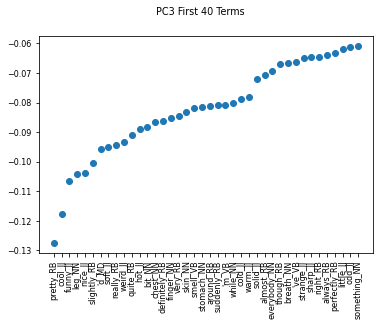

['pretty_RB', 'cool_JJ', 'funny_JJ', 'leg_NN', 'nice_JJ', 'slightly_RB', "'d_MD", 'soft_JJ', 'really_RB', 'weird_JJ', 'quite_RB', 'hot_JJ', 'bit_NN', 'chest_NN', 'definitely_RB', 'finger_NN', 'very_RB', 'skin_NN', 'smell_VB', 'stomach_NN', 'around_RB', 'suddenly_RB', "'m_VB", 'while_NN', 'cold_JJ', 'warm_JJ', 'solid_JJ', 'almost_RB', 'everybody_NN', 'though_RB', 'breath_NN', "'ve_VB", 'strange_JJ', 'sharp_JJ', 'right_RB', 'always_RB', 'perfectly_RB', 'little_JJ', 'odd_JJ', 'something_NN', 'so_RB', 'still_RB', 'guess_VB', 'too_RB', 'heavy_JJ', 'contraction_NN', 'pleasant_JJ', 'touch_VB', 'taste_NN', 'extremely_RB', 'remember_VB', 'empty_JJ', 'enough_RB', "n't_RB", 'amazing_JJ', 'shake_VB', "'re_VB", 'moment_NN', 'body_NN', 'everyone_NN', 'relax_VB', 'ever_RB', 'sudden_JJ', 'somehow_RB', 'anything_NN', 'sensation_NN', 'absolutely_RB', 'totally_RB', 'wake_VB', 'gut_NN', 'dad_NN', 'touch_NN', 'wonderful_JJ', 'someone_NN', 'nauseous_JJ', 'dizzy_JJ', 'never_RB', 'tired_JJ', 'somewhat_RB', 'c

In [ ]:
import matplotlib 
import matplotlib.pyplot as plt
words = 40
# plt.figure(figsize=(30,10))

font = {'family' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)
plt.xticks(rotation=90)
# plt.scatter(loadings_df['variable'][-words:], loadings_df['PC3'][-words:])
plt.scatter(loadings_df['variable'][0:words], loadings_df['PC3'][0:words])
plt.suptitle("PC3 First 40 Terms")
plt.show() # Depending on whether you use IPython or interactive mode, etc.
print(loadings_df["variable"].tolist())

#Clustering

In [ ]:
# https://stackoverflow.com/questions/47321133/sklearn-hierarchical-agglomerative-clustering-using-similarity-matrix

from sklearn.cluster import AgglomerativeClustering

clusters = 3
clustering = AgglomerativeClustering(affinity='precomputed', n_clusters=clusters, linkage='complete').fit(scaled_distance_matrix)
print(clustering.labels_)

index_arrays = list(numpy.argwhere(clustering.labels_ == 2))

for array in index_arrays:
  print(descriptors[array[0]])

[1 2 0 0 2 2 2 1 2 0 0 0 2 0 0 1 0 1 2 2 0 0 2 2 1 2 1 0 2 0 2 2 1 0 0 1 0
 0 2 2 0 0 2 0 2 2 1 0 0 2 1 2 1 2 2 2 1 0 2 0 0 1 0 2 2 2 2 0 1 1 2 0 1 0
 1 2 2 2 2 2 1 0 0 2 2 2 0 0 2 2 2 1 1 2 2 1 2 2 1 1 1 1 0 2 2 0 1 1 1 1 2
 1 2 2 2 1 0 1 1 0 0 0 2 0 1 2 1 2 2 2 2 0 1 2 1 1 0 1 2 0 0 2 0 0 0 1 2 0
 0 1 0 1 0 1 2 2 0 0 1 0 2 0 1 2 1 1 2 0 1 0 2 0 2 2 1 2 2 2 0 0 0 2 2 1 0
 1 2 0 2 2 1 1 2 1 2 0 0 1 0 0 1 2 0 2 0 0 1 0 0 2 1 0 1 2 1 0 2 0 0 1 0 2
 0 0 0 2 1 0 2 1 2 1 0 1 1 2 2 2 1 0 1 0 0 1 2 0 1 0 2 1 2 2 1 0 0 1 2 2 0
 0 2 0 2 1 0 1 0 0 2 2 1 0 0 2 0 0 2 0 0 0 1 2 0 2]
hot_JJ
around_RB
way_NN
remember_VB
ever_RB
heavy_JJ
no_RB
leave_VB
almost_RB
begin_VB
taste_NN
while_NN
mother_NN
imagine_VB
completely_RB
heat_NN
're_VB
'd_MD
've_VB
anything_NN
nice_JJ
absolutely_RB
someone_NN
cool_JJ
familiar_JJ
everybody_NN
amazing_JJ
perfectly_RB
soft_JJ
shake_VB
everyone_NN
still_RB
n't_RB
slightly_RB
'm_VB
never_RB
always_RB
empty_JJ
wonderful_JJ
presence_NN
weak_JJ
cry_VB
right_RB
alone_RB
eart

In [ ]:
print(scaled_distance_matrix.shape)

(284, 284)


In [ ]:
a=[str(i) for i in range(284)]
print(a)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '15

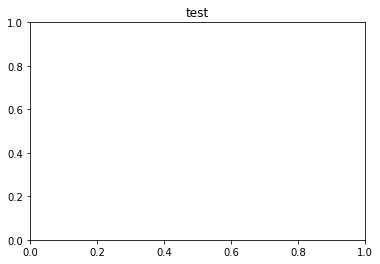

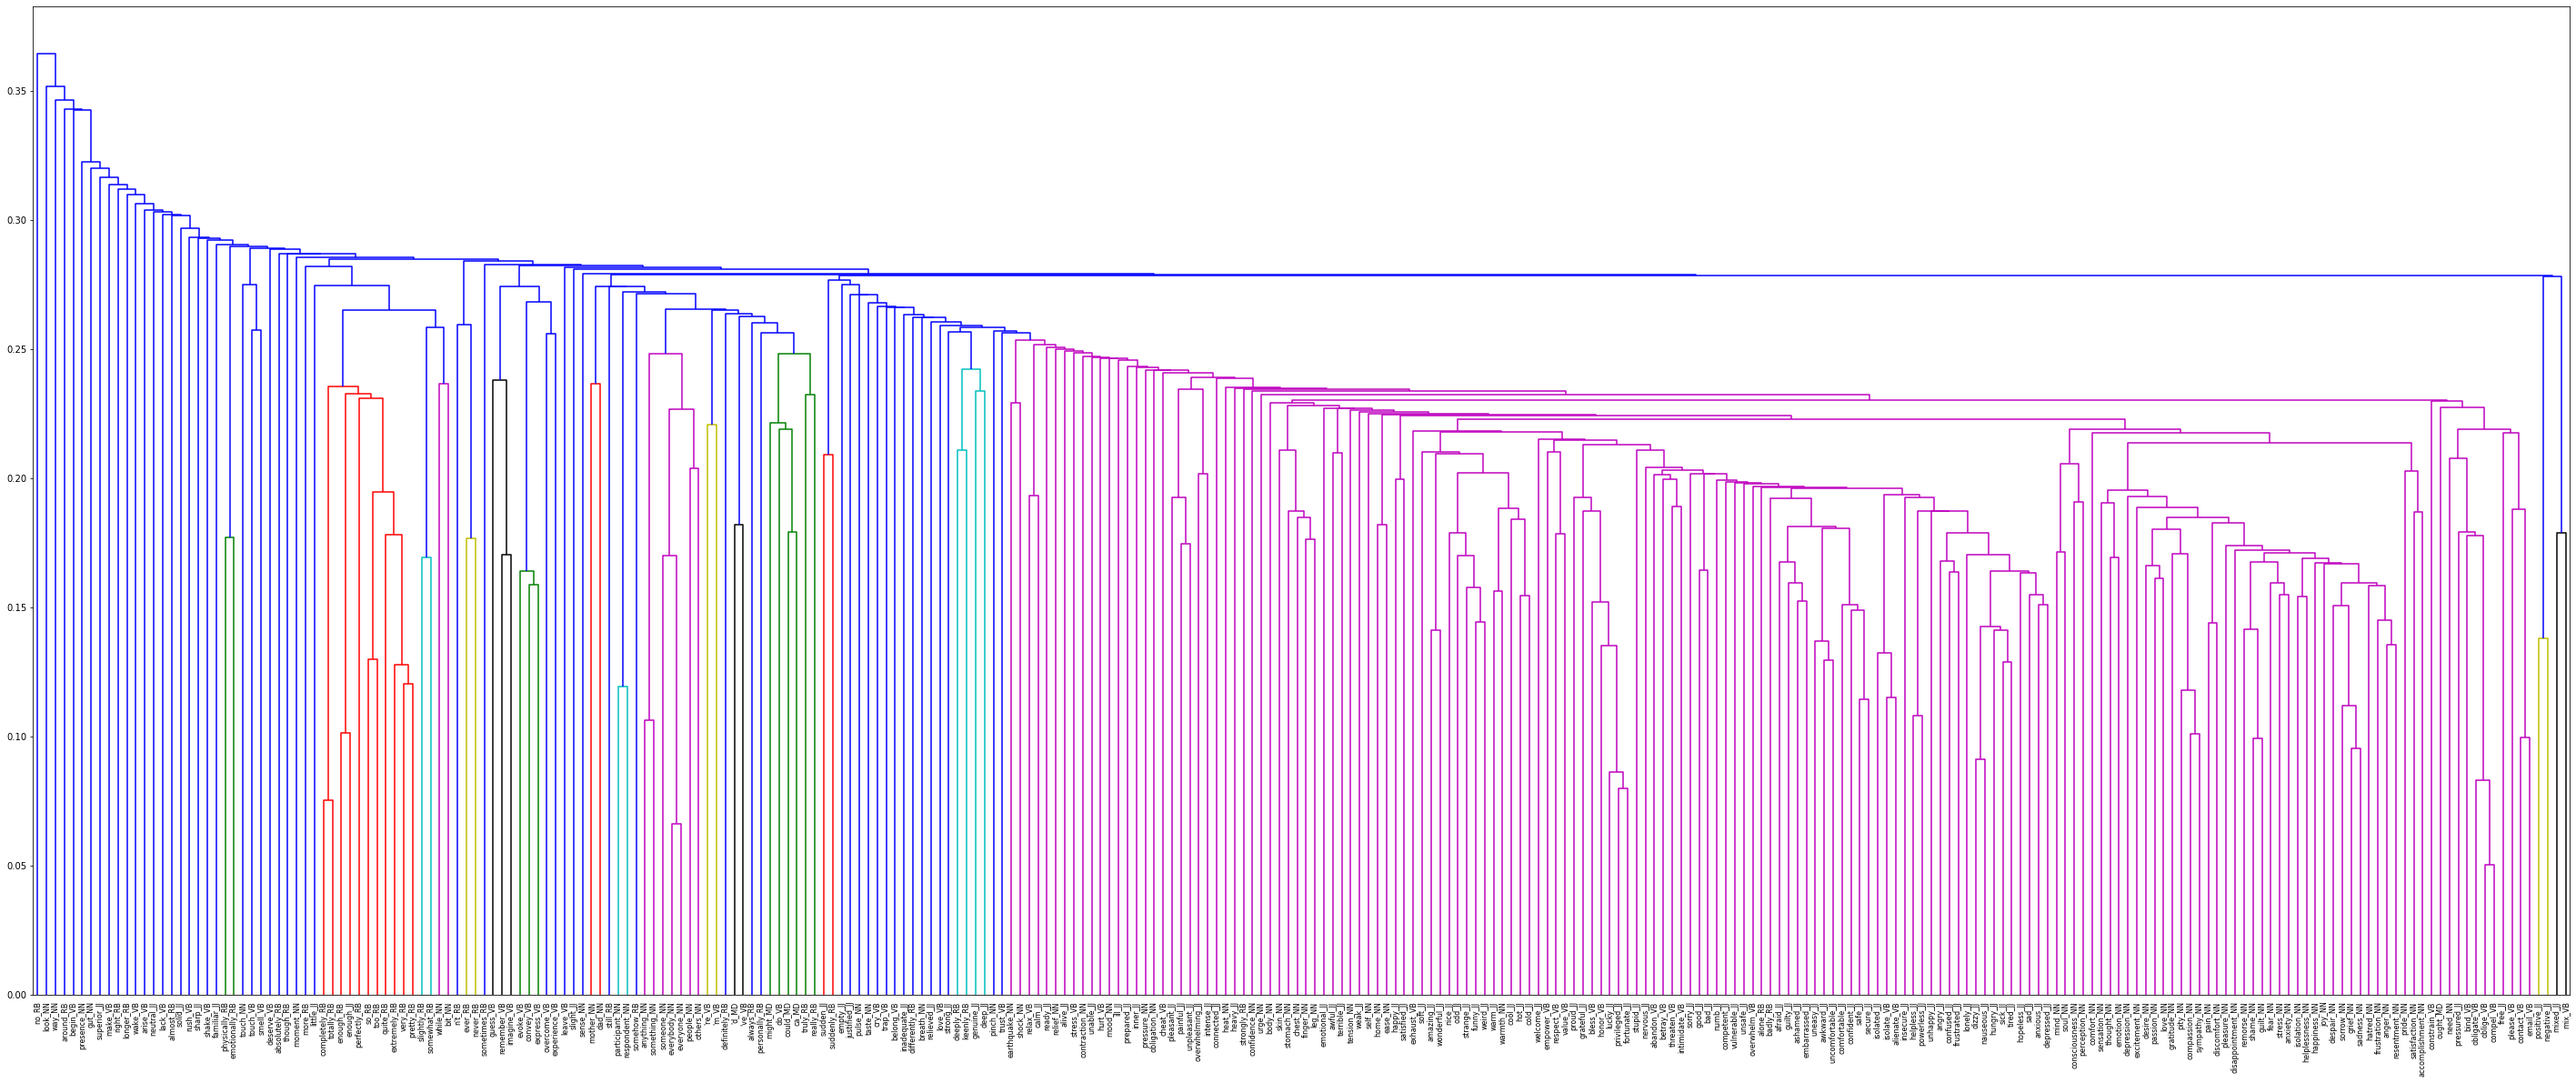

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

# reference: https://stackoverflow.com/questions/41416498/dendrogram-or-other-plot-from-distance-matrix?rq=1

import matplotlib.pyplot as plt

plt.title("test")
plt.figure(figsize=(50,20))
# convert the redundant n*n square matrix form into a condensed nC2 array
# distArray = squareform(scaled_distance_matrix, checks=False)
# linkage_matrix = linkage(distArray, "single")
dendrogram(linkage_matrix, labels=descriptors,
           leaf_rotation=90.,  # rotates the x axis labels
          leaf_font_size=8.,  # font size for the x axis labels)
)
plt.show()

#Identify Contexts

In [ ]:
########## 
#
# Checks if file name already exists. If it does, adds a file nr to it
#
#########
    
def checkFilename(filename, mypath):
    
    # Check if file name already exists
    if os.path.exists(os.path.join(mypath, filename)):
        filenr = [1]
        
        # get files, extension and fname
        files = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
        extension = re.match(r'.*(\..*)$', filename).group(1)
        fname = re.sub(extension, '', filename)
        
        NOs = 0
        # look for file matches
        for f in files:
            cMatch = re.match(fname + '\_([0-9]+)\..*', f)
        
            if cMatch:
                NOs = NOs + 1
                filenr.append(int(cMatch.group(1)))
                
        filenr = max(filenr) + 1
            
        # set new file name
        filename = fname + '_' + str(filenr) + extension     
    return(filename)

In [ ]:
########
# 
# Identify olfactory contexts from fixed UMBC file
#
########
    
def identify_olfactory_contexts(corpusdir, targetdir=[], OlfWords = []):    
    
    ######
    # Setup
    ######
    
    # Get start time
    starttime = time.time()
    
    print('\n\n************************************************************************************************')
    print('Identifying olfactory contexts in UMBC corpus on basis of olfactory words, this will take some time.\n')
    
    # Get file names
    files = [cfile for cfile in os.listdir(corpusdir) if (re.search(r'^UMBC_lines.*', cfile))]
    fileIDs = [re.search(r'_(\d+)\.', i).group(1) for i in files]
    
    # Check taget dir
    if not targetdir:
        print('WARNING. No target dir provided. Saves will be made to corpus directory.\n')
        print('(However, I will adjust the filename of the output files if they already exists.)')
        targetdir = corpusdir
        
        
    # Loop over file IDs
    for fileID in fileIDs:
        cFile = u'UMBC_lines_' + str(fileID) + '.json'
        cOlfFile = u'UMBC_olfIDs_' + str(fileID) + '.json'
        cOlfFile = checkFilename(cOlfFile, targetdir)
        
        print('\nWorking file: ' + cFile + '....')
        
        # load current sentences from file    
        cf = open(os.path.join(corpusdir, cFile), 'r')
        cSentences = json.load(cf)
        cf.close()
        
        # Setup olfactory ID data to putput results to
        olflines = []
        
        # Loop over sentences in current file
        for scount, cSentence in enumerate(cSentences):

            # Loop over words in current sentece
            for cword in cSentence:
                
                # Check for olfactory words in sentence            
                if any([re.search(oword, cword) for oword in OlfWords]):
                    print('.', end='')
                    olflines.append(scount)
                    
        # Current file is done. Dump .json-sentence file and .json-olf ID file
        print('\n' + cFile + ' is done! Saving ' + cOlfFile + '....\n')
        
        cfile = open(os.path.join(targetdir, cOlfFile), 'w')
        json.dump(olflines, cfile)
        cfile.close()
                      
    # All files are done. Report and return POS tags
    print('\n\n********************************************************************')
    print('All files done!\n')
    print('It took ' + str(time.time() - starttime) + ' seconds to work ' + str(len(files)) + ' files.')

In [ ]:
OlfWords = ['^feel_.*$', '^feeling_.*$', '^feelings_.*$', '^feels_.*$', '^felt_.*$']
corpusdir =  '/content/drive/My Drive/umbc/'
targetdir = '/content/drive/My Drive/umbc_context'

In [ ]:
identify_olfactory_contexts(corpusdir, targetdir, OlfWords = OlfWords)



************************************************************************************************
Identifying olfactory contexts in UMBC corpus on basis of olfactory words, this will take some time.


Working file: UMBC_lines_1.json....
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
########
#
# Extracts olfactory descriptors from UMBC corpus
#
########
    
def get_descriptors(corpusdir, descfile = 'DescriptorFile.csv', olffile = 'DescriptorFile_OlfactoryFrequencies.csv', 
                    ctxtdir = [], OlfWords = [], distance = [], POStags = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS', 'COLL'], 
                    ctxtoutdir = 'UMBC Corpus/', save_contexts = False, verbose=False, min_Ns=20, asDataFrame=True, mergePOS=True, olfFrequenciesOnly = False):
   
    ######
    # Setup
    ######
    
    # Get start time
    totalstarttime = time.time() 
    
    # If no context directory is provided, assume that context files are located in same folder
    if not ctxtdir:
        ctxtdir = corpusdir
    
    # Get file names
    cFiles = [cfile for cfile in os.listdir(corpusdir) if (re.search(r'UMBC_lines.*.$', cfile))]
    oFiles = [cfile for cfile in os.listdir(ctxtdir) if (re.search(r'UMBC_olfIDs.*.$', cfile))]
    fileIDs = [re.search(r'_(\d+)\.', i).group(1) for i in cFiles]
    
    # Fix POS search string
    possearch = "(" + "|".join(POStags) + ")"
    
    # setup target dictionary
    descriptors = dict()
    

    #########
    # Loop over files in order to extract descriptor terms and count occurrences in
    # olfactory contexts. Total frequencies are counted later.
    #########
    
    print('\n\n*********************************************************************************************')
    print('Starting to extract olfactory descriptors from the UMBC corpus, this will take some time.\n')
    
    extractstarttime = time.time()

    for idx, cFile in enumerate(cFiles): 
        
        # Get file start time
        filestarttime = time.time()
        
        if verbose:
            print('\nWorking file: ' + cFile + ' (nr ' + str(idx + 1) + ')....')
        
        # load current sentences from file    
        cf = open(os.path.join(corpusdir, cFile), 'r')
        cSentences = json.load(cf)
        cf.close()
        
        # load current olfactory contexts from file 
        cf = open(os.path.join(ctxtdir, oFiles[idx]), 'r')
        cOlfCtxts = set(json.load(cf))
        cf.close()
        
        # If contexts are to be saved, set up output context list
        if save_contexts:
            outContexts = []
        
        # work olfactory contexts
        for cCtxt in cOlfCtxts:
            cs = cSentences[cCtxt]
            
            # get olfactory-related terms and positions in current sentence       
            cOWs = [[cw, x] for x, cw in enumerate(cs) if any([re.search(ow, cw) for ow in OlfWords])]
        
            # Do not continue if any terms have been found 
            if not cOWs:
                continue
            
            # Else loop over identified terms and extract descriptor terms
            cIDs = []
            for cOW in cOWs:
                
                # Identify start word
                start = cOW[1] - distance
                if start < 0:
                    start = 0
                    
                # Identify end word
                end = cOW[1] + distance
                if end > len(cs)-1:
                    end = len(cs)-1
                    
                # calculate word ids
                wds = set(range(start, end+1))
                
                # if contexts are to be saved, append current context together with current sentence number
                if save_contexts:
                    outContexts.append([[cCtxt], [cs[i] for i in wds]])
                
                # remove IDs to olfactory terms
                for c in cOWs:
                    if any([i == c[1] for i in wds]):
                        wds.remove(c[1])
                
                # Remove IDs to unwanted POS words if requested
                if POStags:
                    for w in list(wds):
                        if not (re.search(r'^.*_' + possearch + '$', cs[w])):
                            wds.remove(w)
                
                # Append identified words to cIDs
                cIDs.append(wds)
                
            # Finally join ID sets in cIDs in order to extract final IDs of the current sentence
            IDs = set()
            for cID in cIDs:
                IDs = IDs.union(cID)
                
            # Loop over identified words and add their frequency to the dictionary
            for cID in IDs:
                # Merge POS of current word if requested
                if mergePOS:
                    cw = re.search(r'(^.*_COLL|^.*_..)($|.*$)', cs[cID]).group(1)  
                    cwt = cs[cID]
                    
                # Else just extract word
                else:
                    cw = cs[cID]
                    
                # check if descriptor is already in dictionary, if so, increment count
                if any([d == cw for d in descriptors.keys()]):
                    descriptors[cw][0] += 1
                  
                    # if POSes are merged, check if current token is availible. If not, add it.
                    if mergePOS:
                        if not cwt in descriptors[cw][2]:
                            descriptors[cw][2].append(cwt)
                
                # if not in dictionary, add new item; second item is total frequency, counted later on
                else:
                    # if POSes are merged, add current token
                    if mergePOS:
                        descriptors[cw] = [1, 0, [cwt]]
                    else:
                       descriptors[cw] = [1, 0]
        
        # File is done, report
        if verbose:
            print('Done! It took ' + str(time.time() - filestarttime) + ' seconds to work ' + str(len(cOlfCtxts)) + ' items.')
            
        # If contexts are to be saved, save current output context file
        if save_contexts:
            print(u'Saving current context file in ' + ctxtoutdir + '...\n')
            ctxtFileName = u'UMBC_contexts_' + str(fileIDs[idx]) + '.json'
            cf = open(os.path.join(ctxtoutdir, ctxtFileName), 'w')
            json.dump(outContexts, cf)
            cf.close()
            
    # All files are done, report
    print('\n---------------------------------------------------------------------')
    print('Descriptor term extraction is done!')
    print('It took ' + str(time.time() - extractstarttime) + ' seconds to work ' + str(len(cFiles)) + ' files.')
    
    # If availible, remove descriptors with less than min_Ns tokens
    if min_Ns:
        print('\nRemoving descriptors with less than ' + str(min_Ns) + ' tokens in olfactory contexts...')
        
        # Loop over descriptors
        for cDisc in list(descriptors.keys()):
            if descriptors[cDisc][0] < min_Ns:
                del descriptors[cDisc]
   
    print('Nr of descriptors identified: ' + str(len(descriptors)) + '\n')
        
    if (olfFrequenciesOnly):
        print('Returning and saving olfactory frequencies only as requested....\n')
        
        # Go through descriptors to only include olfactory frequencies
        for dk in list(descriptors.keys()):
            descriptors[dk] = descriptors[dk][0]
        
        if asDataFrame:   
            descriptors = pandas.DataFrame.from_dict(descriptors, orient='index', columns=['OlfN'])
            descriptors.to_csv(descfile)
        
        else:
            cf = open(descfile, 'w')
            json.dump(descriptors, cf)
            cf.close()
        
        return(descriptors) 
        
    if (olffile):
        print('Saving olfactory items before counting total frequencies as requested...\n')
        
        # If to save as data frame
        if asDataFrame:
            
            if mergePOS:  
                pandas.DataFrame.from_dict(descriptors, orient='index', columns=['OlfN', 'TotalN', 'Tokens']).to_csv(olffile)    
            else:
                pandas.DataFrame.from_dict(descriptors, orient='index', columns=['OlfN', 'TotalN']).to_csv(olffile)
        
        else:
            cf = open(olffile, 'w')
            json.dump(descriptors, cf)
            cf.close()

       
    #########
    # Loop over identified descriptors and count total frequencies within each file.
    #########
    
    print('\n********************************************************************************************************')
    print('Starting to count total descriptor frequencies from the UMBC corpus, this will also take time.\n')
    
    freqcountstarttime = time.time()
    
    # Loop over files
    for idx, cFile in enumerate(cFiles): 
        
        if verbose:
            print('\nWorking file: ' + cFile + ' (nr ' + str(idx + 1) +')....')
            print('-------------------------------------')
                
        # Get file start time
        filestarttime = time.time()
            
        # load current sentences from file    
        cf = open(os.path.join(corpusdir, cFile), 'r')
        cSentences = json.load(cf)
        cf.close()
        
        if verbose:
            print('Searching for descriptors in current file...')
            
        # Loop over descriptors
        for cDisc in list(descriptors.keys()):
            
            # Loop over sentences
            for cs in cSentences:
                
                cHits = []
                # Check for occurrences of current descriptor in current sentence
                # if POSes are merged in descriptors, search through all tokens
                if mergePOS:
                    for cdt in descriptors[cDisc][2]: 
                        cHit = [x for x in cs if x == cdt]
                        if cHit:
                            if cHits:
                                cHits.append(cHit)
                            else:
                                cHits = cHit

                else:
                    cHits = [x for x in cs if x == cDisc]
                
                # If current descriptor is in current sentence, increment by no of instances
                if cHits:
                    descriptors[cDisc][1] += len(cHits)
        
        if verbose:            
            print('\n' + cFile + ' is done! It took ' + str(time.time() - filestarttime) + ' seconds to work ' + str(len(cSentences)) + ' items.') 
         
    # File is done, report
    print('\n\n*************************************************************************')
    print('Descriptor frequency count is done!')
    print('It took ' + str(time.time() - freqcountstarttime) + ' seconds to work ' + str(len(descriptors.keys())) + ' descriptors.')
    
    print('\nCalculating OAI and OSI for each term...')
    
    # Get total context frequencies
    tf = sum([descriptors[d][0] for d in descriptors.keys()])
    
    # Calculate OAI and OSI for each term
    for d in descriptors.keys():
       
        # Append OAI 
        descriptors[d].append(numpy.log2(descriptors[d][0] / descriptors[d][1]))
        
        # Append OSI
        descriptors[d].append(-numpy.log2(descriptors[d][0] / tf))
     
    print('\nSaving descriptor data....')

    if asDataFrame: 
        if mergePOS:
                descriptors = pandas.DataFrame.from_dict(descriptors, orient='index', columns=['OlfN', 'TotalN', 'Tokens', 'OAI', 'OSI'])
        else:
                descriptors = pandas.DataFrame.from_dict(descriptors, orient='index', columns=['OlfN', 'TotalN', 'OAI', 'OSI'])
        
        descriptors.to_csv(descfile)
        
    else:
        cf = open(descfile, 'w')
        json.dump(descriptors, cf)
        cf.close()
    
    print('\n\n*****************************************************************')
    print('All done!')
    print('Total processing time: ' + str(time.time() - totalstarttime) + '\n\n')
    return(descriptors)    

In [ ]:
########
#
# Extracts olfactory descriptors from UMBC corpus
#
########
    
def get_descriptors(corpusdir, descfile = 'DescriptorFile.csv', olffile = 'DescriptorFile_OlfactoryFrequencies.csv', 
                    ctxtdir = [], OlfWords = [], distance = [], POStags = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS', 'COLL'], 
                    ctxtoutdir = 'UMBC Corpus/', save_contexts = False, verbose=False, min_Ns=20, asDataFrame=True, mergePOS=True, olfFrequenciesOnly = False):
   
    ######
    # Setup
    ######
    
    # Get start time
    totalstarttime = time.time() 
    
    # If no context directory is provided, assume that context files are located in same folder
    if not ctxtdir:
        ctxtdir = corpusdir
    
    # Get file names
    cFiles = [cfile for cfile in os.listdir(corpusdir) if (re.search(r'UMBC_lines.*.$', cfile))]
    oFiles = [cfile for cfile in os.listdir(ctxtdir) if (re.search(r'UMBC_olfIDs.*.$', cfile))]
    fileIDs = [re.search(r'_(\d+)\.', i).group(1) for i in cFiles]
    
    # Fix POS search string
    possearch = "(" + "|".join(POStags) + ")"
    
    # setup target dictionary
    descriptors = dict()
    

    #########
    # Loop over files in order to extract descriptor terms and count occurrences in
    # olfactory contexts. Total frequencies are counted later.
    #########
    
    print('\n\n*********************************************************************************************')
    print('Starting to extract olfactory descriptors from the UMBC corpus, this will take some time.\n')
    
    extractstarttime = time.time()

    for idx, cFile in enumerate(cFiles): 
        
        # Get file start time
        filestarttime = time.time()
        
        if verbose:
            print('\nWorking file: ' + cFile + ' (nr ' + str(idx + 1) + ')....')
        
        # load current sentences from file    
        cf = open(os.path.join(corpusdir, cFile), 'r')
        cSentences = json.load(cf)
        cf.close()
        
        # load current olfactory contexts from file 
        cf = open(os.path.join(ctxtdir, oFiles[idx]), 'r')
        cOlfCtxts = set(json.load(cf))
        cf.close()
        
        # If contexts are to be saved, set up output context list
        if save_contexts:
            outContexts = []
        
        # work olfactory contexts
        for cCtxt in cOlfCtxts:
            cs = cSentences[cCtxt]
            
            # get olfactory-related terms and positions in current sentence       
            cOWs = [[cw, x] for x, cw in enumerate(cs) if any([re.search(ow, cw) for ow in OlfWords])]
        
            # Do not continue if any terms have been found 
            if not cOWs:
                continue
            
            # Else loop over identified terms and extract descriptor terms
            cIDs = []
            for cOW in cOWs:
                
                # Identify start word
                start = cOW[1] - distance
                if start < 0:
                    start = 0
                    
                # Identify end word
                end = cOW[1] + distance
                if end > len(cs)-1:
                    end = len(cs)-1
                    
                # calculate word ids
                wds = set(range(start, end+1))
                
                # if contexts are to be saved, append current context together with current sentence number
                if save_contexts:
                    outContexts.append([[cCtxt], [cs[i] for i in wds]])
                
                # remove IDs to olfactory terms
                for c in cOWs:
                    if any([i == c[1] for i in wds]):
                        wds.remove(c[1])
                
                # Remove IDs to unwanted POS words if requested
                if POStags:
                    for w in list(wds):
                        if not (re.search(r'^.*_' + possearch + '$', cs[w])):
                            wds.remove(w)
                
                # Append identified words to cIDs
                cIDs.append(wds)
                
            # Finally join ID sets in cIDs in order to extract final IDs of the current sentence
            IDs = set()
            for cID in cIDs:
                IDs = IDs.union(cID)
                
            # Loop over identified words and add their frequency to the dictionary
            for cID in IDs:
                # Merge POS of current word if requested
                if mergePOS:
                    cw = re.search(r'(^.*_COLL|^.*_..)($|.*$)', cs[cID]).group(1)  
                    cwt = cs[cID]
                    
                # Else just extract word
                else:
                    cw = cs[cID]
                    
                # check if descriptor is already in dictionary, if so, increment count
                if any([d == cw for d in descriptors.keys()]):
                    descriptors[cw][0] += 1
                  
                    # if POSes are merged, check if current token is availible. If not, add it.
                    if mergePOS:
                        if not cwt in descriptors[cw][2]:
                            descriptors[cw][2].append(cwt)
                
                # if not in dictionary, add new item; second item is total frequency, counted later on
                else:
                    # if POSes are merged, add current token
                    if mergePOS:
                        descriptors[cw] = [1, 0, [cwt]]
                    else:
                       descriptors[cw] = [1, 0]
        
        # File is done, report
        if verbose:
            print('Done! It took ' + str(time.time() - filestarttime) + ' seconds to work ' + str(len(cOlfCtxts)) + ' items.')
            
        # If contexts are to be saved, save current output context file
        if save_contexts:
            print(u'Saving current context file in ' + ctxtoutdir + '...\n')
            ctxtFileName = u'UMBC_contexts_' + str(fileIDs[idx]) + '.json'
            cf = open(os.path.join(ctxtoutdir, ctxtFileName), 'w')
            json.dump(outContexts, cf)
            cf.close()
            
    # All files are done, report
    print('\n---------------------------------------------------------------------')
    print('Descriptor term extraction is done!')
    print('It took ' + str(time.time() - extractstarttime) + ' seconds to work ' + str(len(cFiles)) + ' files.')
    
    # If availible, remove descriptors with less than min_Ns tokens
    if min_Ns:
        print('\nRemoving descriptors with less than ' + str(min_Ns) + ' tokens in olfactory contexts...')
        
        # Loop over descriptors
        for cDisc in list(descriptors.keys()):
            if descriptors[cDisc][0] < min_Ns:
                del descriptors[cDisc]
   
    print('Nr of descriptors identified: ' + str(len(descriptors)) + '\n')
        
    if (olfFrequenciesOnly):
        print('Returning and saving olfactory frequencies only as requested....\n')
        
        # Go through descriptors to only include olfactory frequencies
        for dk in list(descriptors.keys()):
            descriptors[dk] = descriptors[dk][0]
        
        if asDataFrame:   
            descriptors = pandas.DataFrame.from_dict(descriptors, orient='index', columns=['OlfN'])
            descriptors.to_csv(descfile)
        
        else:
            cf = open(descfile, 'w')
            json.dump(descriptors, cf)
            cf.close()
        
        return(descriptors) 
        
    if (olffile):
        print('Saving olfactory items before counting total frequencies as requested...\n')
        
        # If to save as data frame
        if asDataFrame:
            
            if mergePOS:  
                pandas.DataFrame.from_dict(descriptors, orient='index', columns=['OlfN', 'TotalN', 'Tokens']).to_csv(olffile)    
            else:
                pandas.DataFrame.from_dict(descriptors, orient='index', columns=['OlfN', 'TotalN']).to_csv(olffile)
        
        else:
            cf = open(olffile, 'w')
            json.dump(descriptors, cf)
            cf.close()

       
    #########
    # Loop over identified descriptors and count total frequencies within each file.
    #########
    
    print('\n********************************************************************************************************')
    print('Starting to count total descriptor frequencies from the UMBC corpus, this will also take time.\n')
    
    freqcountstarttime = time.time()
    
    # Loop over files
    for idx, cFile in enumerate(cFiles): 
        
        if verbose:
            print('\nWorking file: ' + cFile + ' (nr ' + str(idx + 1) +')....')
            print('-------------------------------------')
                
        # Get file start time
        filestarttime = time.time()
            
        # load current sentences from file    
        cf = open(os.path.join(corpusdir, cFile), 'r')
        cSentences = json.load(cf)
        cf.close()
        
        if verbose:
            print('Searching for descriptors in current file...')
            
        # Loop over descriptors
        for cDisc in list(descriptors.keys()):
            
            # Loop over sentences
            for cs in cSentences:
                
                cHits = []
                # Check for occurrences of current descriptor in current sentence
                # if POSes are merged in descriptors, search through all tokens
                if mergePOS:
                    for cdt in descriptors[cDisc][2]: 
                        cHit = [x for x in cs if x == cdt]
                        if cHit:
                            if cHits:
                                cHits.append(cHit)
                            else:
                                cHits = cHit

                else:
                    cHits = [x for x in cs if x == cDisc]
                
                # If current descriptor is in current sentence, increment by no of instances
                if cHits:
                    descriptors[cDisc][1] += len(cHits)
        
        if verbose:            
            print('\n' + cFile + ' is done! It took ' + str(time.time() - filestarttime) + ' seconds to work ' + str(len(cSentences)) + ' items.') 
         
    # File is done, report
    print('\n\n*************************************************************************')
    print('Descriptor frequency count is done!')
    print('It took ' + str(time.time() - freqcountstarttime) + ' seconds to work ' + str(len(descriptors.keys())) + ' descriptors.')
    
    print('\nCalculating OAI and OSI for each term...')
    
    # Get total context frequencies
    tf = sum([descriptors[d][0] for d in descriptors.keys()])
    
    # Calculate OAI and OSI for each term
    for d in descriptors.keys():
       
        # Append OAI 
        descriptors[d].append(numpy.log2(descriptors[d][0] / descriptors[d][1]))
        
        # Append OSI
        descriptors[d].append(-numpy.log2(descriptors[d][0] / tf))
     
    print('\nSaving descriptor data....')

    if asDataFrame: 
        if mergePOS:
                descriptors = pandas.DataFrame.from_dict(descriptors, orient='index', columns=['OlfN', 'TotalN', 'Tokens', 'OAI', 'OSI'])
        else:
                descriptors = pandas.DataFrame.from_dict(descriptors, orient='index', columns=['OlfN', 'TotalN', 'OAI', 'OSI'])
        
        descriptors.to_csv(descfile)
        
    else:
        cf = open(descfile, 'w')
        json.dump(descriptors, cf)
        cf.close()
    
    print('\n\n*****************************************************************')
    print('All done!')
    print('Total processing time: ' + str(time.time() - totalstarttime) + '\n\n')
    return(descriptors)    

In [ ]:
OlfWords = ['^feel_.*$', '^feeling_.*$', '^feelings_.*$', '^feels_.*$', '^felt_.*$']
POStags = ['COLL']
NounTags = ['NN', 'NNS', 'NNP', 'NNPS']
AdjTags = ['JJ', 'JJR', 'JJS']
VerbTags = ['MD', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
AdvTags = ['RB', 'RBR', 'RBS']

POStags = POStags + NounTags + AdjTags + VerbTags + AdvTags
print(POStags)

['COLL', 'NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS', 'MD', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'RB', 'RBR', 'RBS']


In [ ]:
descriptors = get_descriptors(corpusdir, OlfWords = OlfWords, distance = 4, ctxtdir = contextdir, POStags=POStags,
                              ctxtoutdir = contextdir, save_contexts = False,
                              asDataFrame = True, mergePOS = False, min_Ns = 10, verbose = True, olfFrequenciesOnly = False)



*********************************************************************************************
Starting to extract olfactory descriptors from the UMBC corpus, this will take some time.


Working file: UMBC_lines_1.json (nr 1)....
Done! It took 5.841550588607788 seconds to work 3681 items.

---------------------------------------------------------------------
Descriptor term extraction is done!
It took 5.84173059463501 seconds to work 1 files.

Removing descriptors with less than 10 tokens in olfactory contexts...
Nr of descriptors identified: 220

Saving olfactory items before counting total frequencies as requested...


********************************************************************************************************
Starting to count total descriptor frequencies from the UMBC corpus, this will also take time.


Working file: UMBC_lines_1.json (nr 1)....
-------------------------------------
Searching for descriptors in current file...

UMBC_lines_1.json is done! It took 79.512

#Calculate OAI from csv

In [ ]:
df = pandas.read_csv("/content/drive/My Drive/DescriptorFile_OlfactoryFrequencies.csv")
df

,Unnamed: 0,OlfN,TotalN,Tokens
0,way_NN,118,0,"['way_NN', 'way_NNS']"
1,state_NN,27,0,"['state_NN', 'state_NNP', 'state_NNPS', 'state..."
2,sure_JJ,16,0,['sure_JJ']
3,be_VB,914,0,"['be_VBD', 'be_VBP', 'be_VBZ', 'be_VB', 'be_VB..."
4,really_RB,39,0,['really_RB']
...,...,...,...,...
244,however_RB,11,0,['however_RB']
245,laughter_NN,10,0,['laughter_NN']
246,fact_NN,10,0,['fact_NN']
247,happy_JJ,10,0,"['happy_JJ', 'happy_JJR']"


In [ ]:
corpusdir =  '/content/drive/My Drive/umbc/'
contextdir = '/content/drive/My Drive/umbc_context/'

In [ ]:
import ast

In [ ]:
dictionary = {}

for r, row in df.iterrows():
  tokens = ast.literal_eval(row["Tokens"])
  key = row["Unnamed: 0"]
  values = [row["OlfN"], row["TotalN"], tokens]
  dictionary[key] = values

In [ ]:
print(dictionary)

{'way_NN': [118, 0, ['way_NN', 'way_NNS']], 'state_NN': [27, 0, ['state_NN', 'state_NNP', 'state_NNPS', 'state_NNS']], 'sure_JJ': [16, 0, ['sure_JJ']], 'be_VB': [914, 0, ['be_VBD', 'be_VBP', 'be_VBZ', 'be_VB', 'be_VBG', 'be_VBN']], 'really_RB': [39, 0, ['really_RB']], 'go_VB': [56, 0, ['go_VBG', 'go_VB', 'go_VBD', 'go_VBP', 'go_VBN']], 'have_VB': [494, 0, ['have_VBP', 'have_VBZ', 'have_VBD', 'have_VB', 'have_VBN', 'have_VBG']], 'nation_NN': [12, 0, ['nation_NNS', 'nation_NN']], 'team_NN': [17, 0, ['team_NN', 'team_NNS', 'team_NNP']], 'learn_VB': [12, 0, ['learn_VB', 'learn_VBD', 'learn_VBP', 'learn_VBG', 'learn_VBN']], 'people_NN': [110, 0, ['people_NNS']], 'so_RB': [129, 0, ['so_RB']], 'many_JJ': [51, 0, ['many_JJ']], 'american_NN': [41, 0, ['american_NNPS', 'american_NNP', 'american_NNS']], 'loss_NN': [16, 0, ['loss_NN', 'loss_NNS']], 'there_RB': [13, 0, ['there_RB']], 'here_RB': [38, 0, ['here_RB']], 'deep_JJ': [22, 0, ['deep_JJ', 'deep_JJR', 'deep_JJS']], 'can_MD': [143, 0, ['can_M

In [ ]:
########
#
# Extracts olfactory descriptors from UMBC corpus
#
########
    
def calculate_scores(corpusdir, dictionary, descfile = 'DescriptorFile.csv', 
                    ctxtdir = [], OlfWords = [], POStags = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS', 'COLL'], 
                    ctxtoutdir = 'UMBC Corpus/', save_contexts = False, verbose=False, asDataFrame=True, mergePOS=True):
   
    ######
    # Setup
    ######
    
    # Get start time
    totalstarttime = time.time() 
    
    # If no context directory is provided, assume that context files are located in same folder
    if not ctxtdir:
        ctxtdir = corpusdir
    
    # Get file names
    cFiles = [cfile for cfile in os.listdir(corpusdir) if (re.search(r'UMBC_lines.*.$', cfile))]
    oFiles = [cfile for cfile in os.listdir(ctxtdir) if (re.search(r'UMBC_olfIDs.*.$', cfile))]
    fileIDs = [re.search(r'_(\d+)\.', i).group(1) for i in cFiles]
    
    # Fix POS search string
    possearch = "(" + "|".join(POStags) + ")"
    
    # setup target dictionary
    descriptors = dictionary
    
    #########
    # Loop over identified descriptors and count total frequencies within each file.
    #########
    
    print('\n********************************************************************************************************')
    print('Starting to count total descriptor frequencies from the UMBC corpus, this will also take time.\n')
    
    freqcountstarttime = time.time()
    
    # Loop over files
    for idx, cFile in enumerate(cFiles): 
        
        if verbose:
            print('\nWorking file: ' + cFile + ' (nr ' + str(idx + 1) +')....')
            print('-------------------------------------')
                
        # Get file start time
        filestarttime = time.time()
            
        # load current sentences from file    
        cf = open(os.path.join(corpusdir, cFile), 'r')
        cSentences = json.load(cf)
        cf.close()
        
        if verbose:
            print('Searching for descriptors in current file...')
            
        # Loop over descriptors
        for cDisc in list(descriptors.keys()):
            
            # Loop over sentences
            for cs in cSentences:
                
                cHits = []
                # Check for occurrences of current descriptor in current sentence
                # if POSes are merged in descriptors, search through all tokens
                if mergePOS:
                    for cdt in descriptors[cDisc][2]: 
                        cHit = [x for x in cs if x == cdt]
                        if cHit:
                            if cHits:
                                cHits.append(cHit)
                            else:
                                cHits = cHit

                else:
                    cHits = [x for x in cs if x == cDisc]
                
                # If current descriptor is in current sentence, increment by no of instances
                if cHits:
                    descriptors[cDisc][1] += len(cHits)
        
        if verbose:            
            print('\n' + cFile + ' is done! It took ' + str(time.time() - filestarttime) + ' seconds to work ' + str(len(cSentences)) + ' items.') 
         
    # File is done, report
    print('\n\n*************************************************************************')
    print('Descriptor frequency count is done!')
    print('It took ' + str(time.time() - freqcountstarttime) + ' seconds to work ' + str(len(descriptors.keys())) + ' descriptors.')
    
    print('\nCalculating OAI and OSI for each term...')
    
    # Get total context frequencies
    tf = sum([descriptors[d][0] for d in descriptors.keys()])
    
    # Calculate OAI and OSI for each term
    for d in descriptors.keys():
       
        # Append OAI 
        descriptors[d].append(numpy.log2(descriptors[d][0] / descriptors[d][1]))
        
        # Append OSI
        descriptors[d].append(-numpy.log2(descriptors[d][0] / tf))
     
    print('\nSaving descriptor data....')

    if asDataFrame: 
        if mergePOS:
                descriptors = pandas.DataFrame.from_dict(descriptors, orient='index', columns=['OlfN', 'TotalN', 'Tokens', 'OAI', 'OSI'])
        else:
                descriptors = pandas.DataFrame.from_dict(descriptors, orient='index', columns=['OlfN', 'TotalN', 'OAI', 'OSI'])
        
        descriptors.to_csv(descfile)
        
    else:
        cf = open(descfile, 'w')
        json.dump(descriptors, cf)
        cf.close()
    
    print('\n\n*****************************************************************')
    print('All done!')
    print('Total processing time: ' + str(time.time() - totalstarttime) + '\n\n')
    return(descriptors)    

In [ ]:
OlfWords = ['^feel_.*$', '^feeling_.*$', '^feelings_.*$', '^feels_.*$', '^felt_.*$']
POStags = ['COLL']
NounTags = ['NN', 'NNS', 'NNP', 'NNPS']
AdjTags = ['JJ', 'JJR', 'JJS']
VerbTags = ['MD', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
AdvTags = ['RB', 'RBR', 'RBS']

POStags = POStags + NounTags + AdjTags + VerbTags + AdvTags
print(POStags)

['COLL', 'NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS', 'MD', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'RB', 'RBR', 'RBS']


In [ ]:
corpusdir =  '/content/drive/My Drive/umbc/'
contextdir = '/content/drive/My Drive/umbc_context/'

In [ ]:
descriptors = calculate_scores(corpusdir, dictionary=dictionary,  
                               ctxtdir=contextdir,
                               OlfWords=OlfWords, POStags=POStags, ctxtoutdir=contextdir,
                               save_contexts=False, verbose=True, asDataFrame=True, mergePOS=True)


********************************************************************************************************
Starting to count total descriptor frequencies from the UMBC corpus, this will also take time.


Working file: UMBC_lines_1.json (nr 1)....
-------------------------------------
Searching for descriptors in current file...

UMBC_lines_1.json is done! It took 180.40636444091797 seconds to work 348382 items.


*************************************************************************
Descriptor frequency count is done!
It took 180.40722918510437 seconds to work 249 descriptors.

Calculating OAI and OSI for each term...

Saving descriptor data....


*****************************************************************
All done!
Total processing time: 180.4192225933075


